In [20]:
import tensorflow as tf
from tensorflow import keras
import pathlib
import collections
import matplotlib.pyplot as plt
import concurrent.futures
import requests
import hashlib
import itertools
import tqdm

In [21]:
def flickr8k(path='../data/flickr8k'):
  path = pathlib.Path(path)

  if len(list(path.rglob('*'))) < 16197:
    keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)
    keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)

  captions = (path/"Flickr8k.token.txt").read_text().splitlines()
  captions = (line.split('\t') for line in captions)
  captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

  cap_dict = collections.defaultdict(list)
  for fname, cap in captions:
    cap_dict[fname].append(cap)

  train_files = (path/'Flickr_8k.trainImages.txt').read_text().splitlines()
  train_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in train_files]

  test_files = (path/'Flickr_8k.testImages.txt').read_text().splitlines()
  test_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in test_files]

  train_ds = tf.data.experimental.from_list(train_captions)
  test_ds = tf.data.experimental.from_list(test_captions)

  return train_ds, test_ds

In [22]:
def conceptual_captions(*, data_dir="../data/conceptual_captions", num_train, num_val):
  def iter_index(index_path):
    with open(index_path) as f:
      for line in f:
        caption, url = line.strip().split('\t')
        yield caption, url

  def download_image_urls(data_dir, urls):
    ex = concurrent.futures.ThreadPoolExecutor(max_workers=100)
    def save_image(url):
      hash = hashlib.sha1(url.encode())
      # Name the files after the hash of the URL.
      file_path = data_dir/f'{hash.hexdigest()}.jpeg'
      if file_path.exists():
        # Only download each file once.
        return file_path

      try:
        result = requests.get(url, timeout=5)
      except Exception:     # Bad I know but chalega ek bar ke liye
        file_path = None
      else:
        file_path.write_bytes(result.content)
      return file_path

    result = []
    out_paths = ex.map(save_image, urls)
    for file_path in tqdm.tqdm(out_paths, total=len(urls)):
      result.append(file_path)

    return result

  def ds_from_index_file(index_path, data_dir, count):
    data_dir.mkdir(exist_ok=True)
    index = list(itertools.islice(iter_index(index_path), count))
    captions = [caption for caption, url in index]
    urls = [url for caption, url in index]

    paths = download_image_urls(data_dir, urls)

    new_captions = []
    new_paths = []
    for cap, path in zip(captions, paths):
      if path is None:
        # Download failed, so skip this pair.
        continue
      new_captions.append(cap)
      new_paths.append(path)

    new_paths = [str(p) for p in new_paths]

    ds = tf.data.Dataset.from_tensor_slices((new_paths, new_captions))
    ds = ds.map(lambda path,cap: (path, cap[tf.newaxis])) # 1 caption per image
    return ds

  data_dir = pathlib.Path(data_dir)
  train_index_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/gcc-data/Train/GCC-training.tsv',
    cache_subdir=data_dir,
    cache_dir='.')

  val_index_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/gcc-data/Validation/GCC-1.1.0-Validation.tsv',
    cache_subdir=data_dir,
    cache_dir='.')

  train_raw = ds_from_index_file(train_index_path, data_dir=data_dir/'train', count=num_train)
  test_raw = ds_from_index_file(val_index_path, data_dir=data_dir/'val', count=num_val)

  return train_raw, test_raw

In [23]:
flickr_train, flickr_test = flickr8k()
conc_train, conc_test = conceptual_captions(num_train=20000, num_val=5000)

100%|██████████| 5000/5000 [00:11<00:00, 444.62it/s]


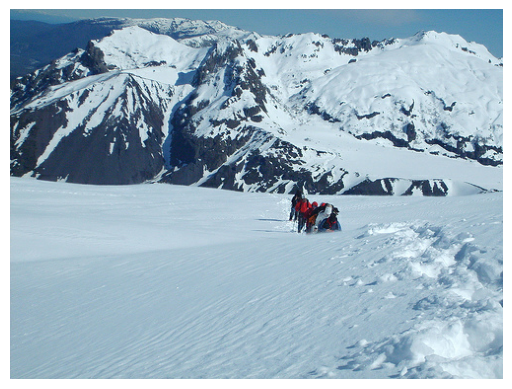

A group of mountain climbers
A group of people walking in a line through the snow toward a mountain .
A line of people are making their way through snow covered mountains .
People are walking through a snow covered field with a mountain the background .
People facing mountains in the snow .


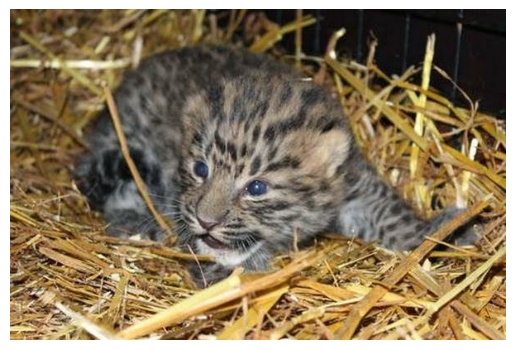

funny animals of the week , animal pictures


In [28]:
for ds in [flickr_train, conc_train]:
    for img_path, captions in ds.skip(30).take(1):
    
        img_raw = tf.io.read_file(img_path.numpy().decode("utf-8"))
        image = tf.image.decode_image(img_raw)
    
        plt.imshow(image)
        plt.axis('off') 
        plt.show()
    
        for caption in captions.numpy():
            print(caption.decode("utf-8"))